In [1]:
#data manipulation import
import pandas as pd
import numpy as np

#graphs import
import plotly.express as px
import matplotlib.pyplot as plt
from plotly.offline import download_plotlyjs, init_notebook_mode, plot
init_notebook_mode(connected=True)
cf.go_offline()
import plotly.graph_objects as go
from plotly.subplots import make_subplots

#Tensorflow import
import tensorflow as tf
from tensorflow import feature_column
from tensorflow.keras import layers

#Sci-kit learn import data split
from sklearn.model_selection import train_test_split

In [2]:
#Getting all data from csv files
train_df = pd.read_csv('./housing/train.csv')
test_df = pd.read_csv('./housing/test.csv', na_values=['nan'])

In [3]:
train_df.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

In [4]:
train=train_df[['OverallQual', 'GrLivArea', 'GarageCars', '1stFlrSF', 'TotalBsmtSF', 'FullBath', 'YearBuilt', 'SalePrice']].copy()

In [20]:
#Standardizing values in train and test dataframe
column_names=['OverallQual', 'GrLivArea', 'GarageCars', '1stFlrSF', 'TotalBsmtSF', 'FullBath', 'YearBuilt', 'SalePrice']

def standardize(dataframe, columns):
    for name in columns:
        dataframe[name] = (dataframe[name] - dataframe[name].mean()) / dataframe[name].std()
    return dataframe

train = standardize(train, column_names)

train = train.drop(train[train.SalePrice > 5.4].index)

In [6]:
#Transforming dataframe to tensorflow dataset method
def df_to_dataset(dataframe, shuffle=True, batch_size=32):
    dataframe=dataframe.copy()
    labels = dataframe.pop('SalePrice')
    ds = tf.data.Dataset.from_tensor_slices((dict(dataframe),labels))
    if shuffle:
        ds = ds.shuffle(buffer_size=len(dataframe))
    ds = ds.batch(batch_size)
    return ds

In [68]:
#spliting train data for train and validation and then transforming all data to tensorflow dataset
batch_size=16
train, val =  train_test_split(train, test_size=0.01)
train_ds = df_to_dataset(train, batch_size=batch_size)
val_ds = df_to_dataset(val, shuffle=False, batch_size=batch_size)

In [8]:
#Creating Feature Columns Layer

feature_columns = []

for name in column_names[0:-1]:
    feature_columns.append(feature_column.numeric_column(name))
    
feature_layer = tf.keras.layers.DenseFeatures(feature_columns)

In [74]:
#Creating Tensorflow Keras Model using only nurmeric features

regularizer=tf.keras.regularizers.L1L2(l1 = 0.01, l2=0.02)

model = tf.keras.Sequential([
    feature_layer,
    layers.Dense(7, activation='tanh', kernel_regularizer=regularizer),
    layers.Dense(14, activation='tanh', kernel_regularizer=regularizer),
    layers.Dense(1, activation='tanh'),
])

optimizer = tf.keras.optimizers.Adam(
    learning_rate=0.01)

model.compile(optimizer=optimizer,
              loss=tf.keras.losses.MeanSquaredError(name='mean_squared_error'),
              metrics=['mean_squared_error'])

history = model.fit(train_ds,
          validation_data=val_ds,
          epochs=120)

Epoch 1/120
Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.
 1/49 [..............................] - ETA: 0s - loss: 1.7868 - mean_squared_error: 1.0771WARNING:tensorflow:Layers in a Sequential model should only have a single input tensor, but we receive a <class 'dict'> input: {'OverallQual': <tf.Tensor 'ExpandDims_4:0' shape=(None, 1) dtype=float64>, 'GrLivArea': <tf.Tensor 'ExpandDims_3:0' shape=(None, 1) dtype=float64>, 'GarageCars': <tf.Tensor 'ExpandDims_2:0' shape=(None, 1) dtype=float64>, '1stFlrSF': <tf.Tensor 'ExpandDims:0' shape=(None, 1) dtype=float64>, 'TotalBsmtSF': <tf.Tensor 'ExpandDims_5:0' shape=(None, 1) dtype=float64>, 'FullBath': <tf.Tensor 'ExpandDims_1:0' shape=(None, 1) dtype=float64>, 'YearBuilt': <tf.Tensor 'ExpandDims_6:0' shape=(None, 1) dtype=float64>}
Consider rewriting this model with the Functional API.
49/49 [==============================] - 0s 5ms/step - loss: 0.8573 - mean_squared_error: 0

49/49 [==============================] - 0s 1ms/step - loss: 0.2992 - mean_squared_error: 0.2796 - val_loss: 1.2626 - val_mean_squared_error: 1.2436
Epoch 89/120
49/49 [==============================] - 0s 1ms/step - loss: 0.2998 - mean_squared_error: 0.2808 - val_loss: 1.2699 - val_mean_squared_error: 1.2503
Epoch 90/120
49/49 [==============================] - 0s 1ms/step - loss: 0.3016 - mean_squared_error: 0.2819 - val_loss: 1.2734 - val_mean_squared_error: 1.2546
Epoch 91/120
49/49 [==============================] - 0s 1ms/step - loss: 0.3020 - mean_squared_error: 0.2823 - val_loss: 1.2709 - val_mean_squared_error: 1.2519
Epoch 92/120
49/49 [==============================] - 0s 1ms/step - loss: 0.3080 - mean_squared_error: 0.2875 - val_loss: 1.2623 - val_mean_squared_error: 1.2428
Epoch 93/120
49/49 [==============================] - 0s 1ms/step - loss: 0.3043 - mean_squared_error: 0.2831 - val_loss: 1.3140 - val_mean_squared_error: 1.2878
Epoch 94/120
49/49 [=====================

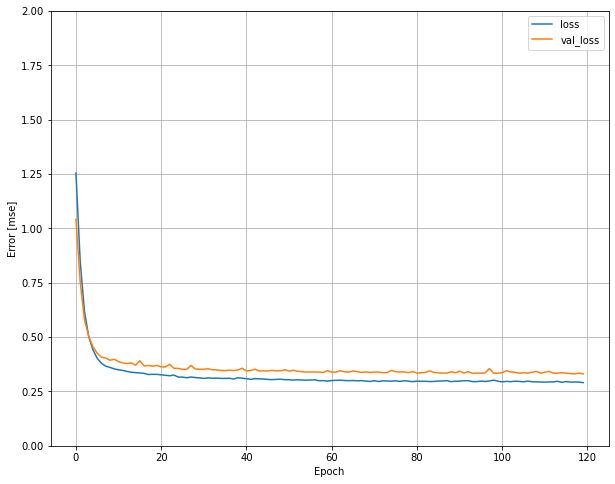

In [10]:
#Plotting loss to epochs function using matplotlib

def plot_loss(history):
    plt.figure(figsize=(10,8))
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.ylim([0, 2])
    plt.xlabel('Epoch')
    plt.ylabel('Error [mse]')
    plt.legend()
    plt.grid(True)

plot_loss(history)

In [75]:
#Making predictions using first model and comparing first 10 positions
test=test_df[['OverallQual', 'GrLivArea', 'GarageCars', '1stFlrSF', 'TotalBsmtSF', 'FullBath', 'YearBuilt']].copy()
test = standardize(test, ['OverallQual', 'GrLivArea', 'GarageCars', '1stFlrSF', 'TotalBsmtSF', 'FullBath', 'YearBuilt'])

predicts = model.predict(dict(test))

predicts = predicts * train_df['SalePrice'].std() + train_df['SalePrice'].mean()
predicts.size

Consider rewriting this model with the Functional API.


1459

In [60]:
#Plotting loss to epochs function using plotly express

loss_fig = px.line(history.history, y=['loss', 'val_loss'],
                   labels={'index':'Epochs',
                           'value': 'Loss Value',
                           'variable': ''}
                  )
loss_fig.show()

In [76]:
submission_df = pd.DataFrame(predicts)

In [77]:
submission_df.index = range(1461, 2920)
submission_df

,0
1461,116286.968750
1462,154547.531250
1463,163828.875000
1464,182660.703125
1465,213295.671875
...,...
2915,110880.093750
2916,113393.304688
2917,144856.421875
2918,117102.281250


In [78]:
submission_df.columns = ['SalePrice']
submission_df['Id'] = submission_df.index

In [79]:
submission_df = submission_df.reindex(columns=['Id', 'SalePrice'])
submission_df.index = range(0, len(submission_df))
submission_df=submission_df.fillna(submission_df.SalePrice.mean())
submission_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Id         1459 non-null   int64  
 1   SalePrice  1459 non-null   float32
dtypes: float32(1), int64(1)
memory usage: 17.2 KB


In [80]:
submission_df.to_csv('submission.csv', index=False)